In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage.color
from shapely.geometry import box
from skimage import transform
from tqdm.notebook import tqdm
from sklearn.cluster import MiniBatchKMeans

import time

start_time = time.time()

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

europe = skimage.color.rgba2rgb(plt.imread('input/europe_medioevo.png'))
display_img(europe, 'Europe Medioevo', True)

def disp_polygons(img, polygons, saveTo='') :
    todisp = img.copy()
    for polygon in polygons :
        (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
        colour = int(np.max(todisp))
        cv2.rectangle(todisp, (minx, miny), (maxx, maxy), (0, 0, colour), 2)
    display_img(todisp, '', True)
    if saveTo :
        plt.imsave(saveTo, todisp)
                      
def fill_polygons(img, polygons, fill_colors):
    res = img.copy()
    if np.ndim(fill_colors) == 1:
        fill_colors = [list(fill_colors)] * len(polygons)
    for i, polygon in enumerate(polygons) :
        [_, (xb, yb), _, (xa, ya), _] = [(int(x), int(y)) for (x, y) in polygon.exterior.coords]
        res[ya:yb, xa:xb] = fill_colors[i]
    return res
def display_colours(color_list) :
    size = len(color_list)
    plt.figure(figsize=(18,8))
    plt.bar(range(size), [1]*size  , color=color_list, )
    plt.show()

def get_surrounding_colors(img, polygon : box):
    offset = 1
    color_list = np.zeros((len(polygon.exterior.coords) , 3))
    x_left = int(np.array(polygon.exterior.coords)[:, 0].min()) - offset
    x_right = int(np.array(polygon.exterior.coords)[:, 0].max()) + offset
    y_top = int(np.array(polygon.exterior.coords)[:, 1].min()) - offset
    y_bottom = int(np.array(polygon.exterior.coords)[:, 1].max()) + offset
    corners =np.concatenate((
        img[y_top, x_left:x_right],
        img[y_bottom, x_left:x_right],
        img[y_top:y_bottom, x_left],
        img[y_top:y_bottom, x_right],
    ))
    res = np.median(corners, axis=0)
    return res
    
    
population_text_box = box(10, 230, 600, 1050)
logo_text_box = box(10, 10, 170, 150)
year_text_box_1 = box(800, 10, 1040, 150)
year_text_box_2 = box(1030, 30, 1070, 130)

to_remove = [population_text_box, logo_text_box, year_text_box_1, year_text_box_2]
surrounding_colors = [get_surrounding_colors(europe, box) for box in to_remove]
disp_polygons(europe, to_remove)

europe_cleaned = fill_polygons(europe, to_remove, surrounding_colors)
#europe_cleaned = transform.resize(europe_cleaned, (europe_cleaned.shape[0]/10, europe_cleaned.shape[1]/10))
plt.imsave('tmp/europe_cleaned.png', europe_cleaned)
display_img(europe_cleaned, 'Only map data are kept', True)

<Figure size 1440x1280 with 1 Axes>

<Figure size 1440x1280 with 1 Axes>

<Figure size 1440x1280 with 1 Axes>

# Pre define the colors

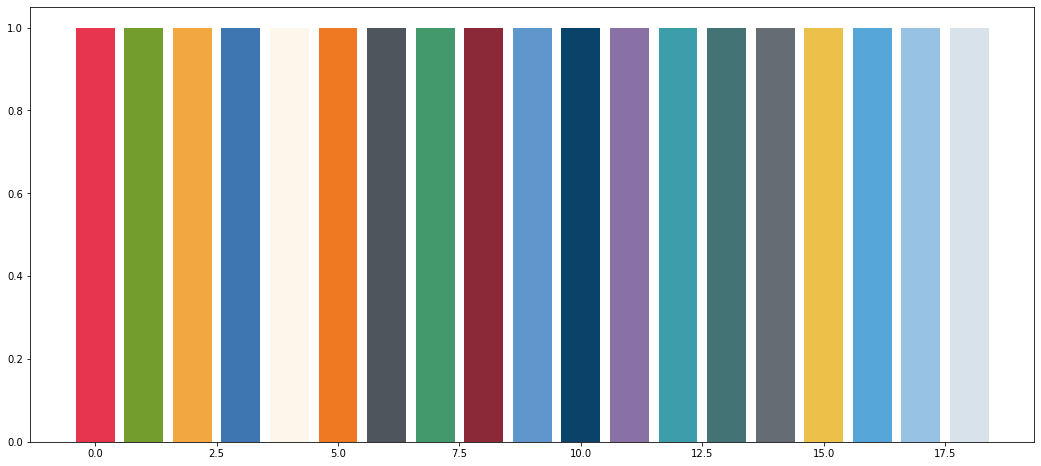

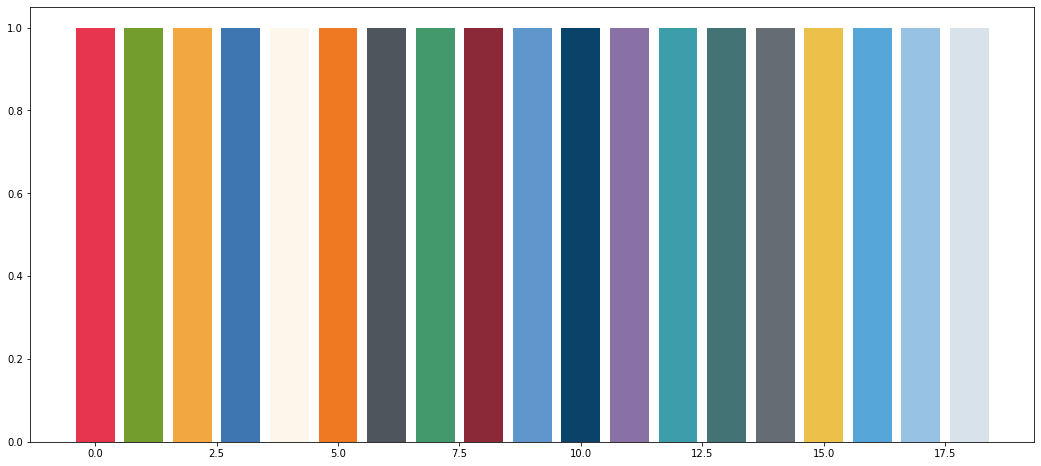

In [2]:
map_colors = ['#E73550' , 
'#739D2D' , 
'#F2A740' , 
'#3E76B2' , 
'#FCF7EA' , 
'#EE7922' , 
'#4E555C' , 
'#43996C' , 
'#8C2939' , 
'#5F97CC' , 
'#09436A' , 
'#8A71A5' , 
'#3C9DAB' , 
'#437375' , 
'#666c74' , 
'#ecc149' , 
'#56a6da' , 
'#98c2e4' , 
'#D8E2EB' ]
display_colours(map_colors)
def hex_to_rgb(hex_value) :
    h = hex_value.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]
map_colors_rgb = np.array([hex_to_rgb(color) for color in map_colors])/255
display_colours(map_colors_rgb)



# Determine cluster centers

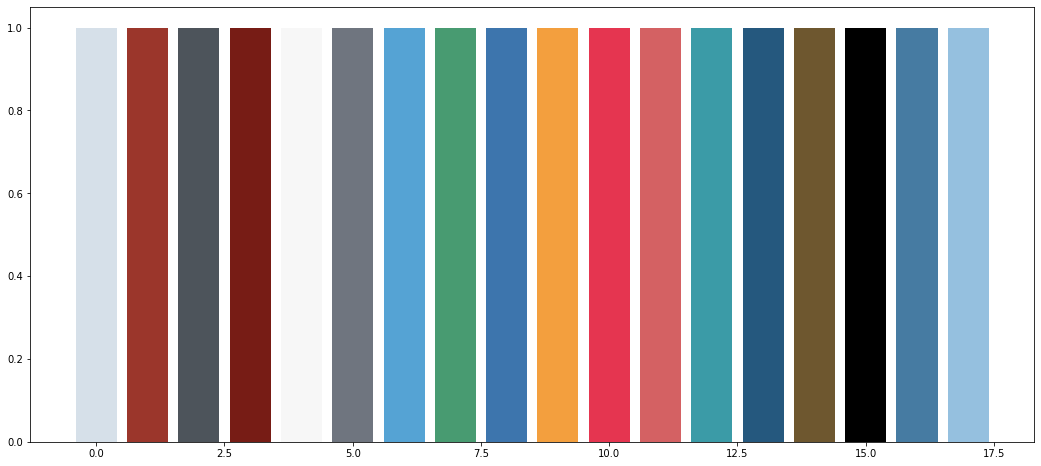

out of 22


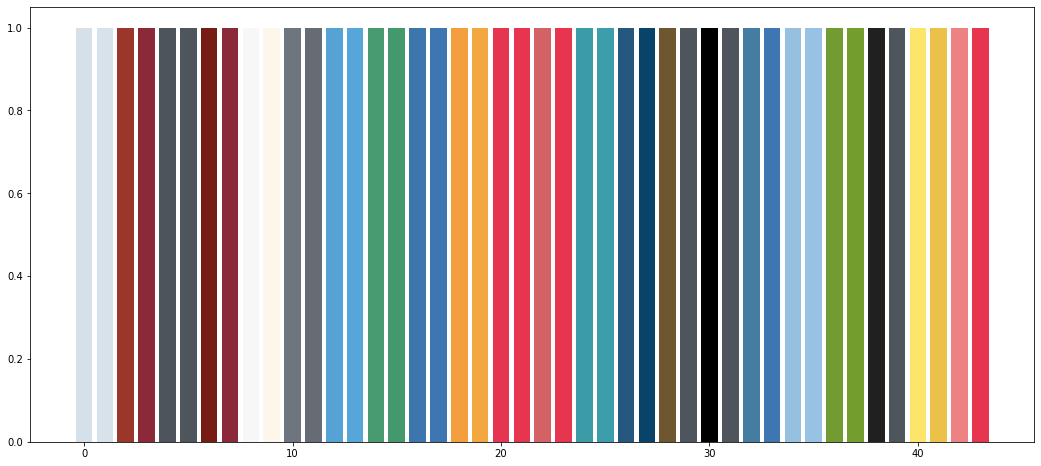

In [3]:
def colour_distance(rgb1, rgb2):
    [[lab1, lab2]] = skimage.color.rgb2lab([[rgb1, rgb2]])
    return np.linalg.norm(lab1 - lab2)


def determine_major_colors(map_image):
    count_colors = np.unique(map_image.reshape(int(map_image.size/3), 3) , axis=0,return_counts=True)
    stacked = np.column_stack((count_colors[0][:,0], count_colors[0][:,1], count_colors[0][:,2], count_colors[1]))
    stacked = [tuple(row) for row in stacked]
    stacked = np.array(stacked, dtype=[('r', float), ('g', float), ('b', float),  ('count', int)])
    major_colors = np.sort(stacked, order='count')[::-1]
    major_colors = [[tup[0], tup[1], tup[2]] for tup in major_colors]
    return major_colors
major_colors = determine_major_colors(europe_cleaned)[:300]
color_retained = []
for color in major_colors:
    distances = [colour_distance(color, c) for c in color_retained]
    if not distances or min(distances) > 10:
        color_retained.append(color)
    
display_colours(color_retained[:18])
print('out of '+str(len(color_retained)))
put_together = []
for color in color_retained:
    distances = [colour_distance(color, c) for c in map_colors_rgb]
    put_together.append(color)
    put_together.append(map_colors_rgb[np.argmin(distances)])
display_colours(put_together)


In [4]:
def regroup_colors(image, initial_colors) :
    (h, w) = image.shape[:2]
    # Lab is a colour representation (l, a , b). 
    # The kmeans computes an euclidian distance, lab is made so that if the perceived colour differ, the euclidian distance differs more than an rgb euclidian distance
    data = skimage.color.rgb2lab(image)
    initial_centers = skimage.color.rgb2lab([initial_colors])[0]
    clt = MiniBatchKMeans(n_clusters = len(initial_colors), init=initial_centers)
    labels = clt.fit_predict(data.reshape((h*w, 3)))
    res = clt.cluster_centers_[labels].reshape((h, w, 3))
    res = skimage.color.lab2rgb(res)
    return res


clustered = regroup_colors(europe_cleaned, color_retained[:20])


/home/noan/miniconda3/envs/mapisto/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:998: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  return self.fit(X, sample_weight=sample_weight).labels_


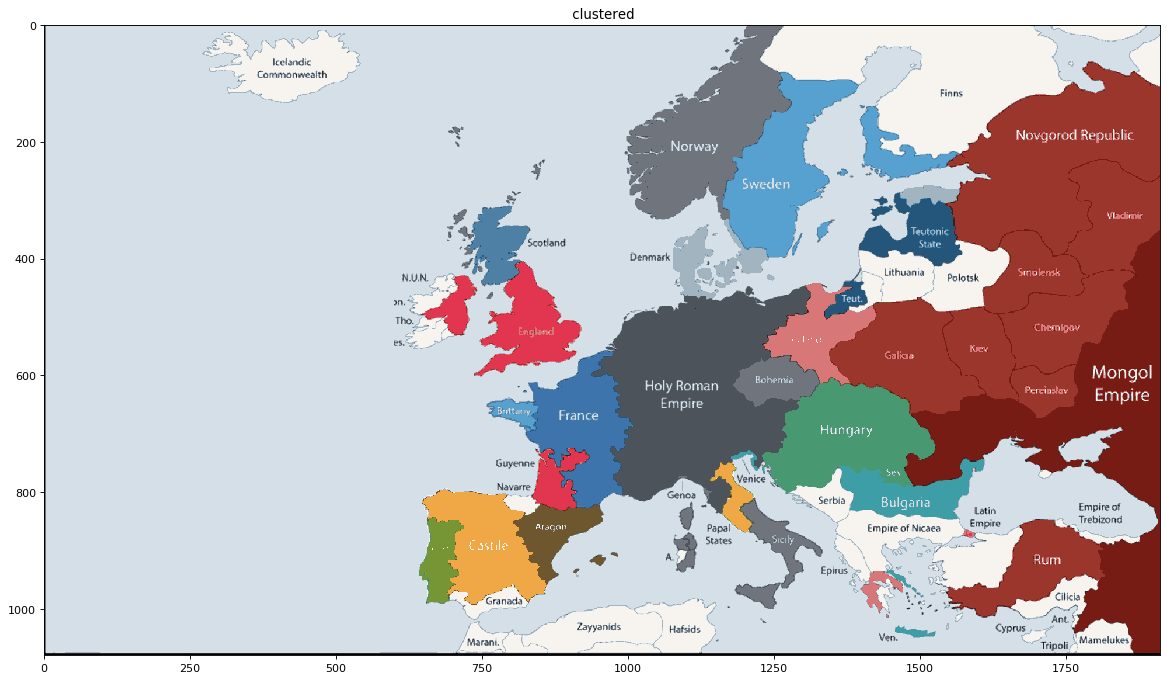

In [5]:
display_img(clustered," clustered", True)


In [6]:
from skimage.filters import median
from skimage import measure
from shapely.geometry import Polygon

def extract_land_color(gray_img):
    count_colors = np.unique(gray_img, return_counts=True)
    count_colors = np.array(list(zip(count_colors[0], count_colors[1])), dtype=[('color', float), ('count', int)])
    grayscale_major_colors = np.sort(count_colors, order='count')[::-1]['color']
    sea_color = grayscale_major_colors[0]
    return [col for col in grayscale_major_colors if abs(col-sea_color)>.005]

def get_polygons(mask):
    contours = measure.find_contours(mask, 0.8)
    return [Polygon(list(zip(contour[:, 1], contour[:, 0]))) for contour in contours]

def is_contained(polygon, other_polygons):
    for potential_container in other_polygons:
        if polygon.within(potential_container):
            return True
    return False

def get_color_filtered_polygons(clustered_image):
    #Passing everything in grayscale
    #print("passing in gray")
    grayscale_map = skimage.color.rgb2gray(clustered_image)
    #print('color count')
    grayscale_major_colors = extract_land_color(grayscale_map)
    #print('mask extraction')
    mask_all = [grayscale_map==gray_color for gray_color in grayscale_major_colors]
    #print('mask cleanup')
    mask_all = [median(mask, selem=np.ones((3, 3))) for mask in tqdm(mask_all)]
    
    # Commented out as time costly
    #erode = lambda img : skimage.morphology.erosion(img, skimage.morphology.disk(6))
    #not_empty = lambda img : np.count_nonzero(img) > 0
    #mask_all = [mask for mask in mask_all if not_empty(erode(mask))]
    polygons = np.concatenate([get_polygons(mask) for mask in mask_all])
    #print(f'len raw pol : {len(polygons)}')
    polygons = [pol for pol in polygons if pol.area >60]
    #print(f'len big pol : {len(polygons)}')
    polygons = [pol for pol in polygons if pol.area/pol.length >2]
    #print(f'len poll not to thin : {len(polygons)}')
    polygons = [pol for pol in polygons if pol.area < clustered.shape[0]*clustered.shape[1]/2 ]
    #print(f'len pol no so big after all : {len(polygons)}')
    polygons = [pol for i, pol in enumerate(polygons) 
                if not is_contained(pol,np.concatenate((polygons[:i], polygons[i+1:])))]
    #print(f'len pol not contained : {len(polygons)}')
    return polygons


    
pols = get_color_filtered_polygons(clustered)


In [7]:
from shapely.geometry import MultiPolygon
def draw_polygon_contour(img, polygon, color, thickness=1):
    res = img.copy()
    if isinstance(polygon, MultiPolygon):
        for pol in polygon.geoms:
            res = draw_polygon_contour(res, pol, color)
        return res
    else:
        mask = np.zeros(res.shape[:2]).astype(bool)
        coords = np.array(polygon.exterior.coords)
        rr, cc = skimage.draw.polygon_perimeter(coords[:, 1], coords[:, 0])
        mask[rr,cc] = True
        if thickness > 1:
            mask = skimage.morphology.dilation(mask, selem=skimage.morphology.disk(thickness))
        res[mask] = color
    return res

def draw_polygons(img, polygons, colors=None):
    assert colors is None or len(colors)==len(polygons)
    res = img.copy()
    for i, polygon in tqdm(enumerate(polygons), total=len(polygons)) :
        coords = np.array(polygon.exterior.coords)
        rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
        if colors is None :
            pixels = europe[rr, cc]
            color= np.median(pixels, axis=0)
        else:
            color=colors[i]
        res[rr, cc] = color
    return res

def find_polygon_color(base_img, polygon, quantile = .5):
    coords = np.array(polygon.exterior.coords)
    rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
    pixels = base_img[rr, cc]
    return np.quantile(pixels, q=quantile, axis=0)


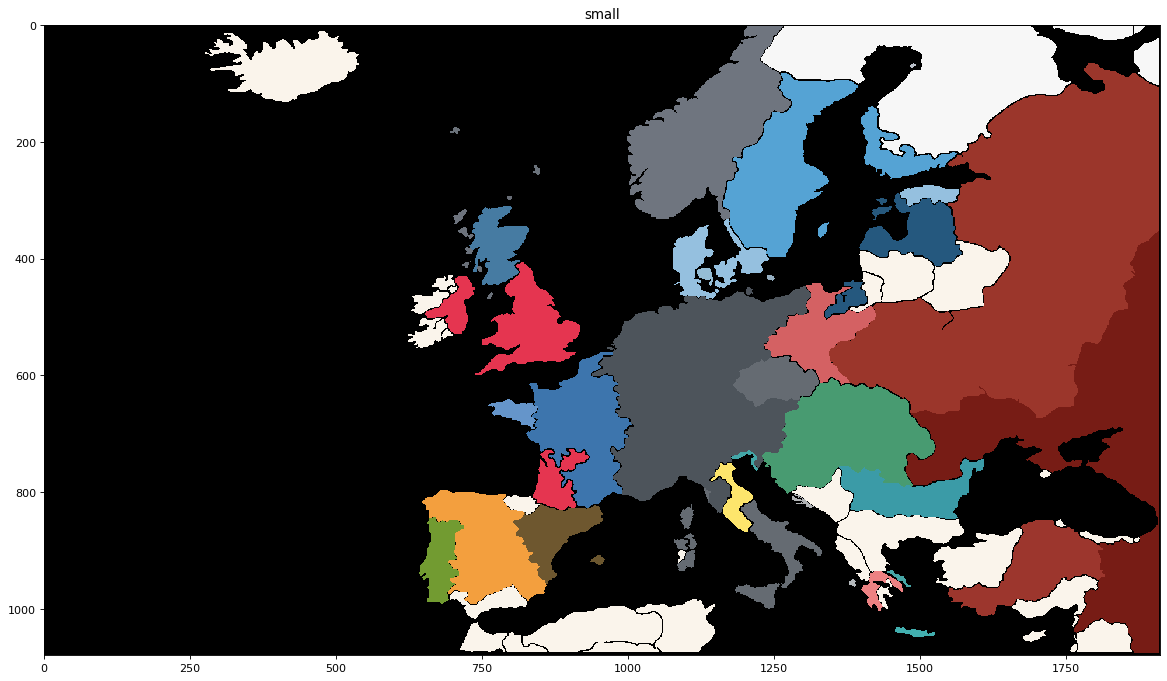

In [8]:
a = europe
a = draw_polygons(np.zeros(europe.shape), pols)
display_img(a, "small", True)


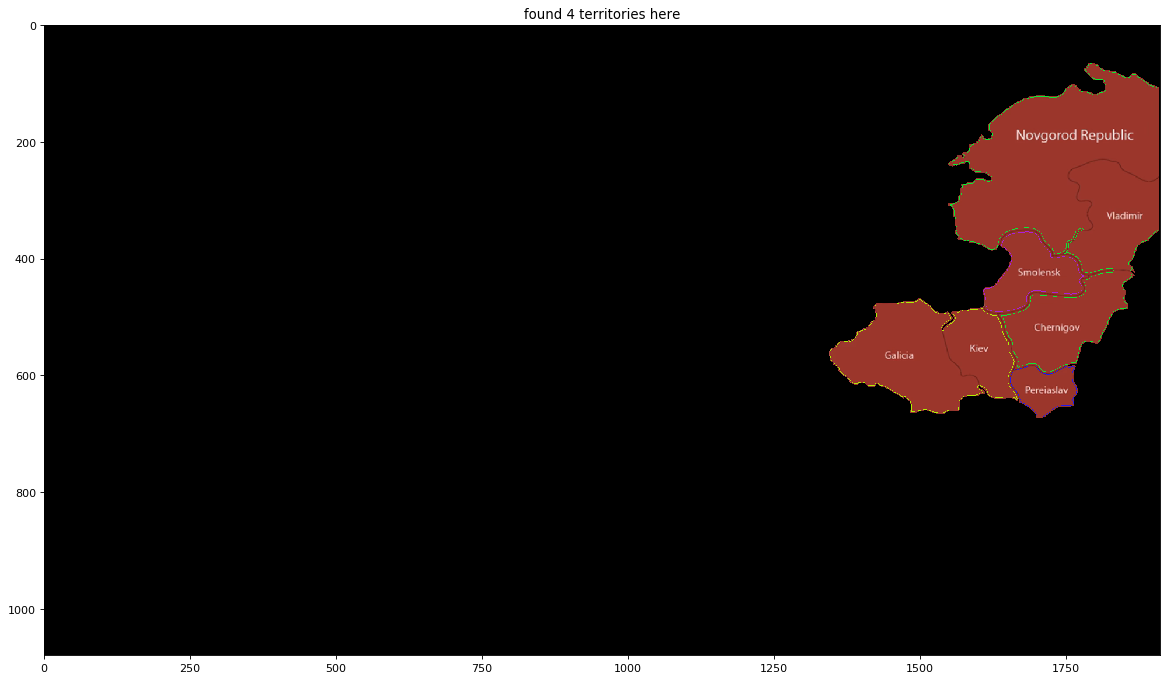

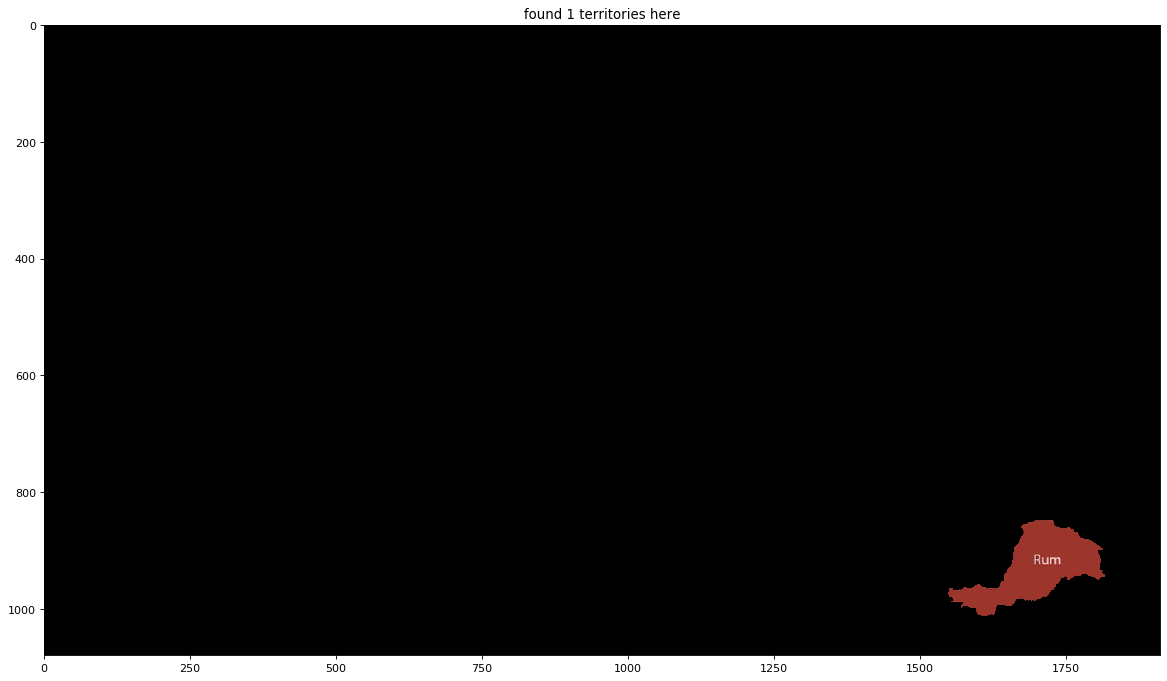

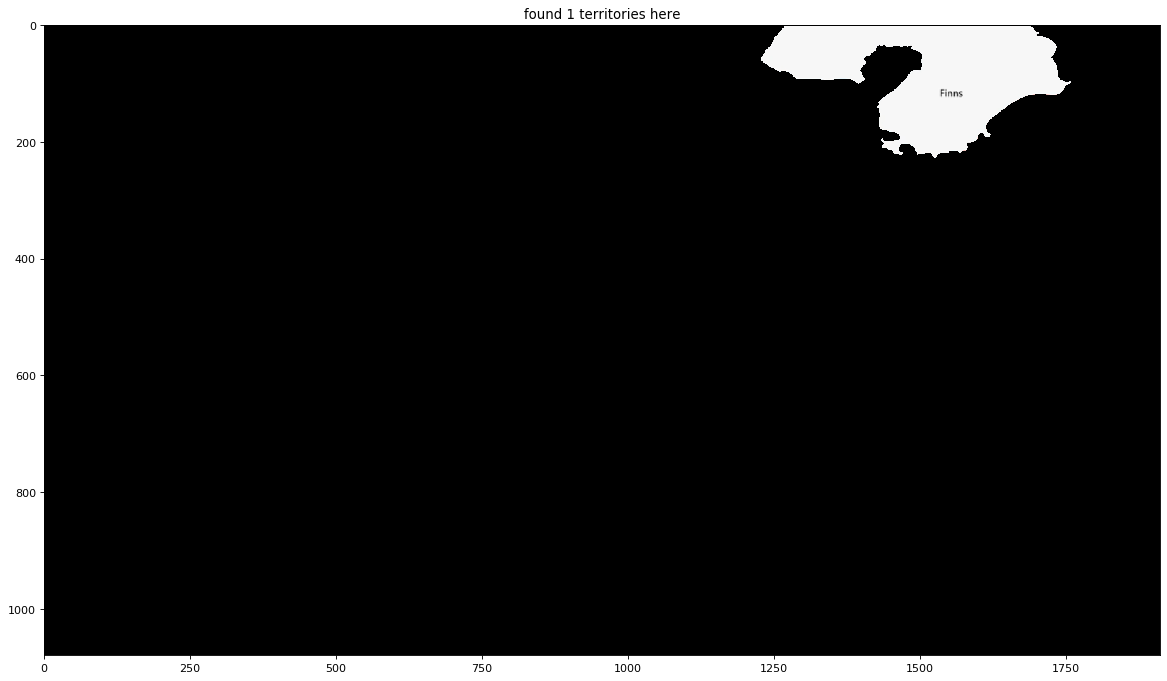

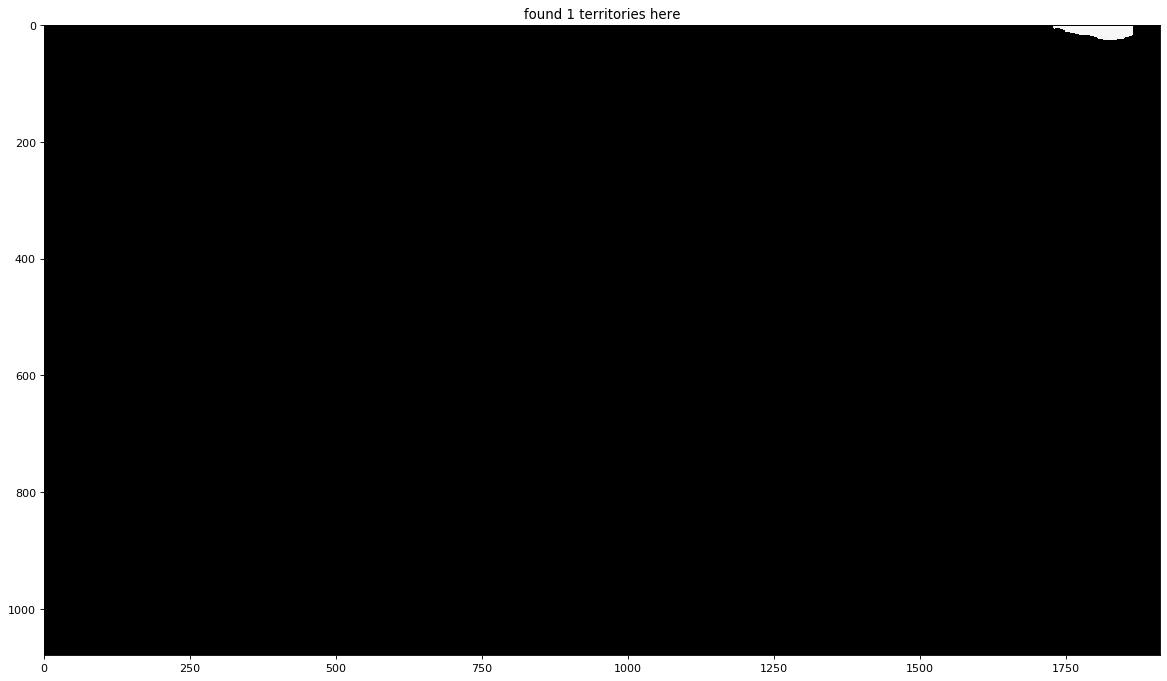

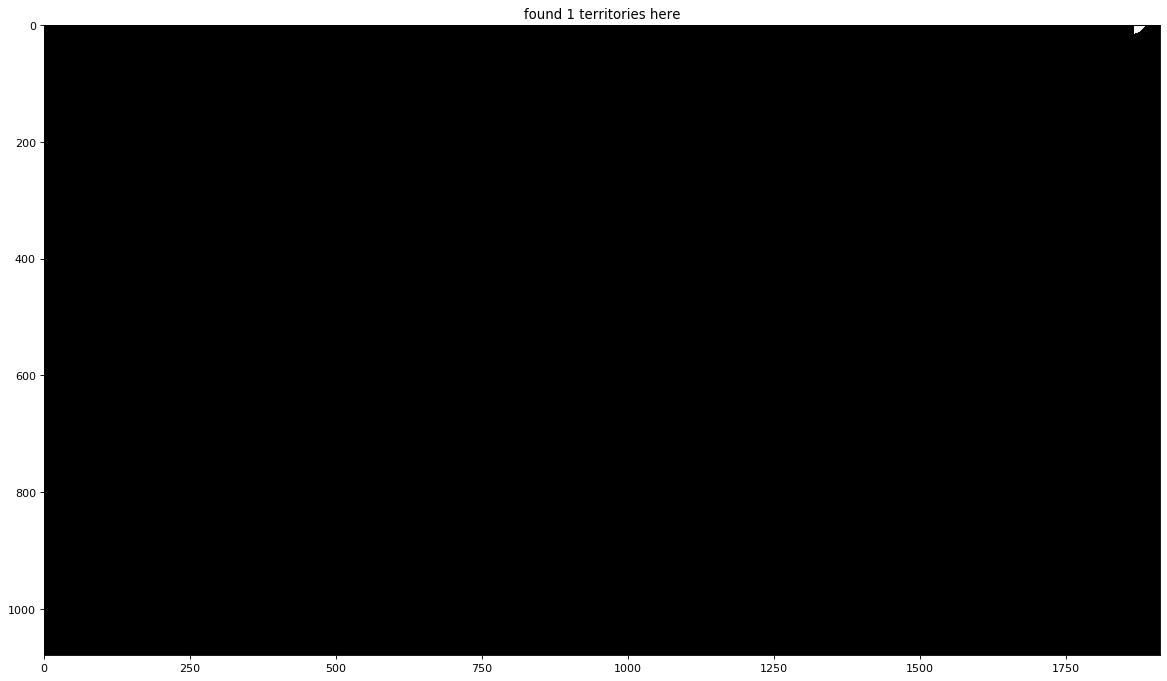

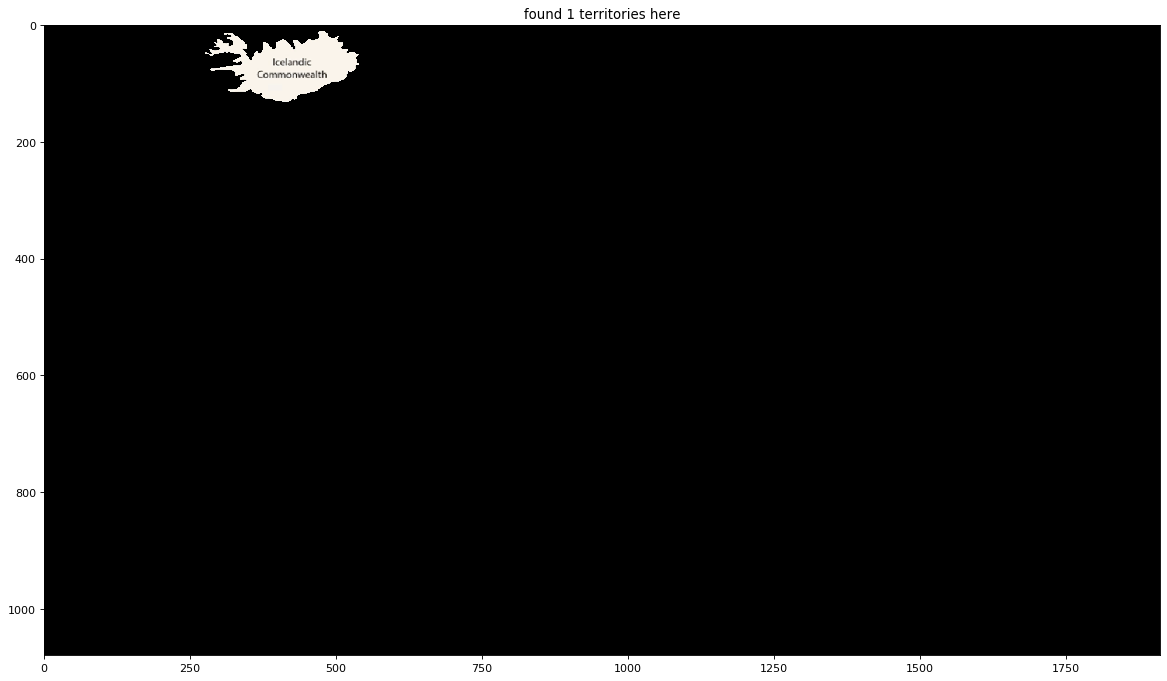

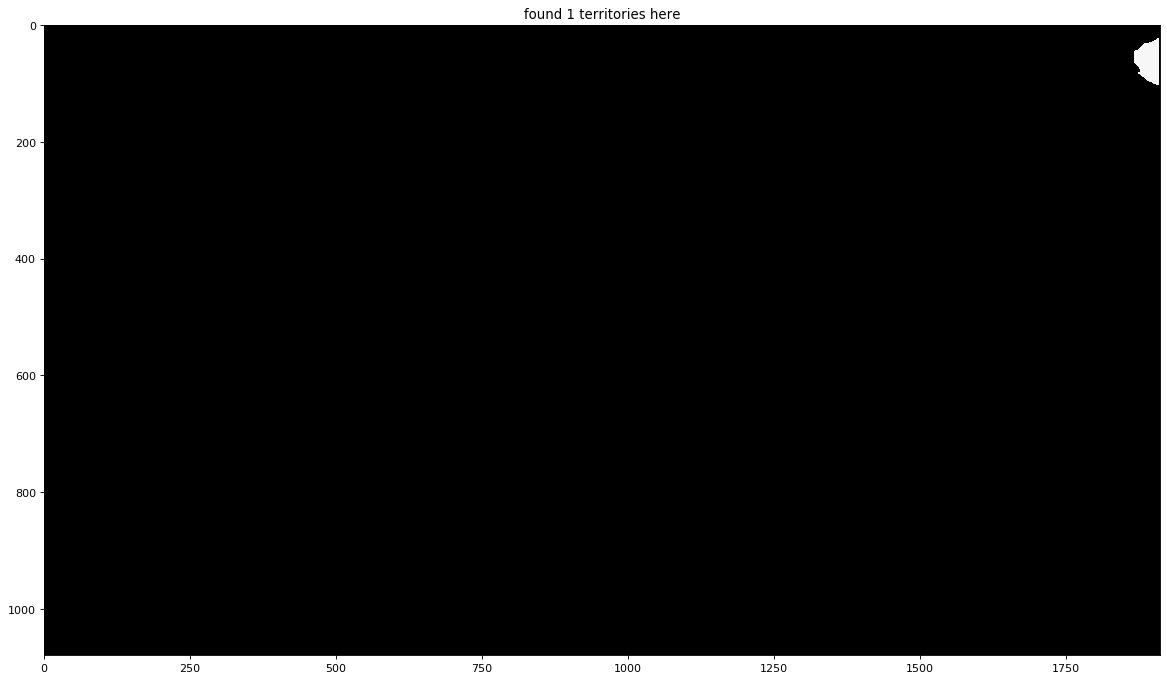

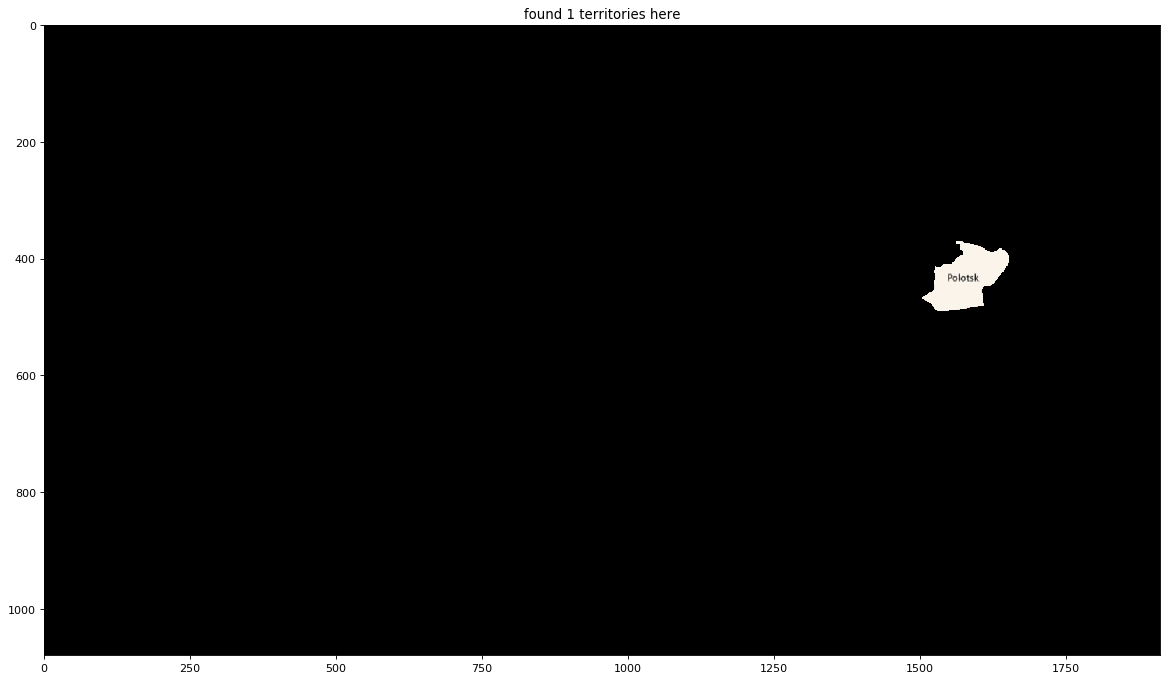

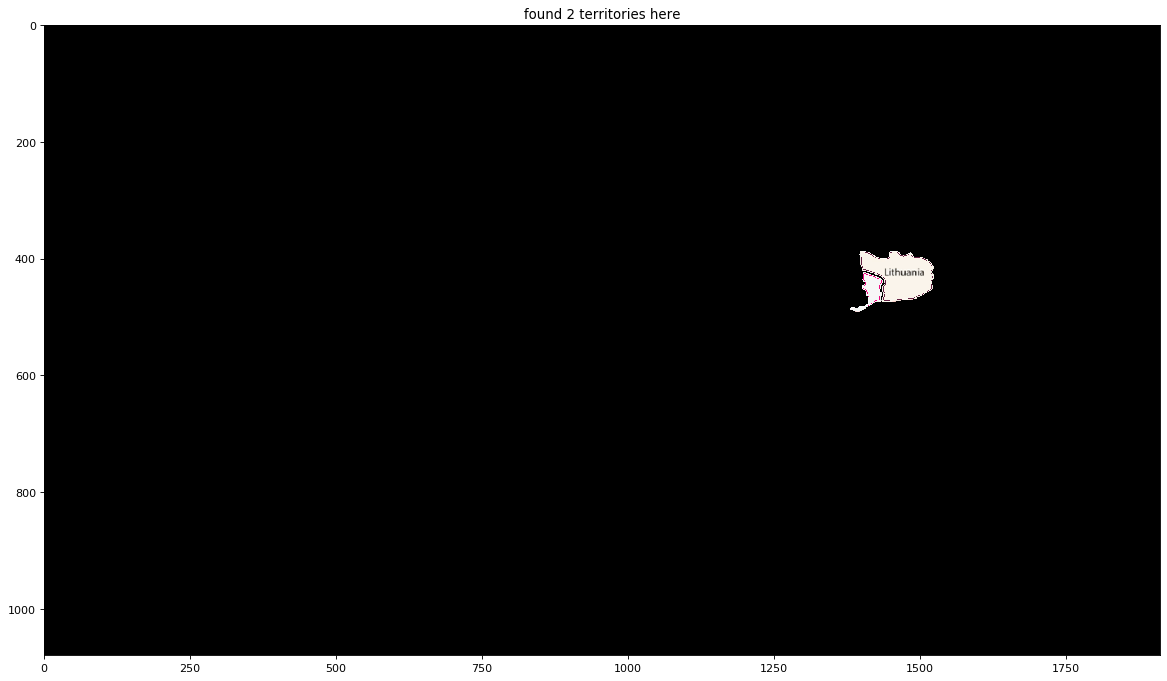

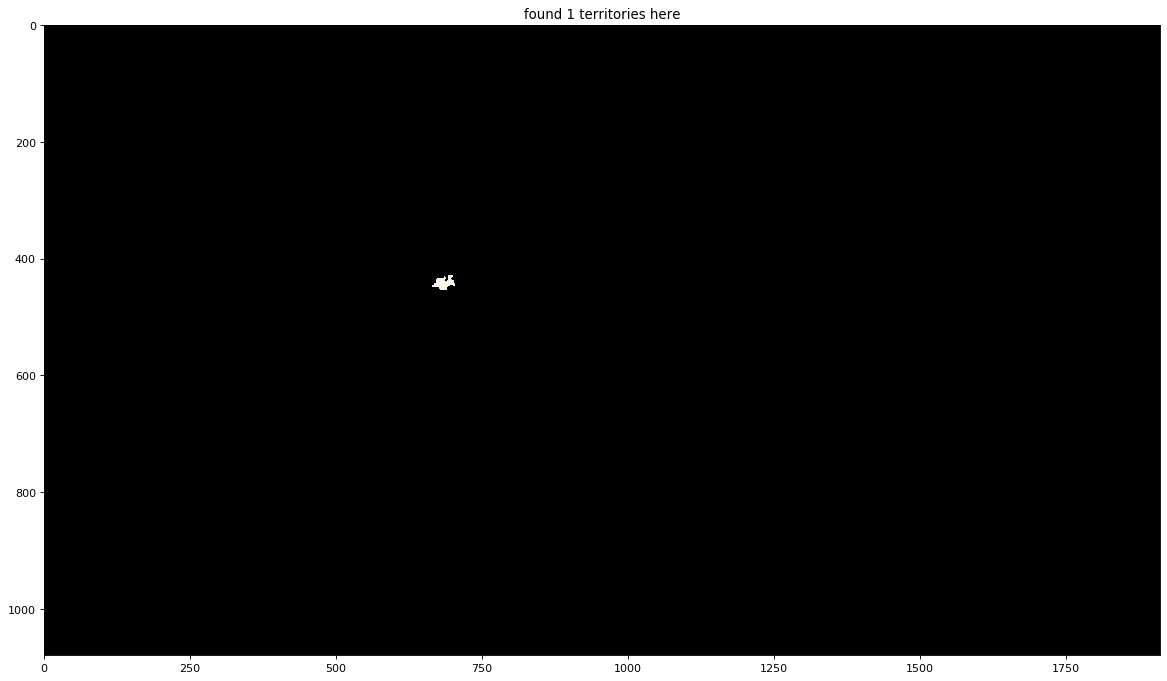

In [9]:
from skimage import feature
import functools

def colour_distance(rgb1, rgb2):
    [[lab1, lab2]] = skimage.color.rgb2lab([[rgb1, rgb2]])
    return np.linalg.norm(lab1 - lab2)


def extract_color_and_mask(img, polygon):
    res = img.copy()
    coords = np.array(polygon.exterior.coords)
    rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
    mask = np.ones(img.shape[:2]).astype(bool)
    mask[rr, cc] = False
    color= np.median(img[rr, cc], axis=0)
    res[mask] = 0
    return color, res

def is_contained(polygon, other_polygons):
    for potential_container in other_polygons:
        if polygon.within(potential_container):
            return True
    return False

def remove_wrapper_polygons(polygons):
    with_area=np.array([[pol, pol.area] for pol in polygons])
    polygons_sorted = with_area[with_area[:,1].argsort()][::-1][:,0]
    to_remove = []
    for i, potential_wrapper in enumerate(polygons_sorted[:-1]):
        smaller_pols = polygons_sorted[i+1:]
        potential_contained = functools.reduce(lambda a,b : a.union(b), smaller_pols)
        intersection_area = potential_wrapper.intersection(potential_contained).area
        ratio = intersection_area/potential_wrapper.area
        if False:
            img = draw_polygon_contour(np.zeros(europe.shape), potential_wrapper, [0,0,1], 1)
            display_img(img[200:800,1000:1800], "blop", True)
            #raise Exception('stop')

            display_img(draw_polygon_contour(img, potential_contained, [1,0,0]), f"Blue versus red, wrapper proba : {ratio}, area length ratio {potential_wrapper.area / potential_wrapper.length}", True)

        if ratio > .6:
            to_remove.append(i)
    return [pol for i,pol in enumerate(polygons) if i not in to_remove]

def remove_contained(atomic_polygons):
    to_remove = []
    for pol in atomic_polygons:
        other = [p for p in atomic_polygons if p is not pol]
        if len(other)!=len(atomic_polygons) -1:
            raise Exception("wsh")
        common_area = [pol.intersection(o).area for o in other]
        if max(common_area) > .9 * pol.area:
            to_remove.append(pol)
    return [p for p in atomic_polygons if p not in to_remove]
            
def split_territory(territory_color, masked_img):
    edges = feature.canny(skimage.color.rgb2gray(masked_img))
    fat_edges = skimage.morphology.dilation(edges, skimage.morphology.disk(2))
    #display_img(fat_edges[200:800,1000:1800], "canny", True)
    inner_polygons = [p for p in get_polygons(fat_edges) if p.area > 60]
    if len(inner_polygons) > 1:
        inner_polygons_atomic = remove_wrapper_polygons(inner_polygons)
    else :
        inner_polygons_atomic = inner_polygons
    if len(inner_polygons_atomic) > 1:
        inner_polygons_atomic = remove_contained(inner_polygons_atomic)
    return inner_polygons_atomic


for pol in tqdm(pols[:10]):
    color, masked = extract_color_and_mask(europe, pol)
    inner_territories = split_territory(color, masked)
    if len(inner_territories) > 1:
        for terr in inner_territories : 
            masked = draw_polygon_contour(masked, terr, np.random.rand(3))
    display_img(masked, f"found {len(inner_territories)} territories here", True)


In [10]:
final = []
for pol in tqdm(pols):
    color, masked = extract_color_and_mask(europe, pol)
    inner_territories = split_territory(color, masked)
    final = np.concatenate((final, inner_territories if len(inner_territories) > 1 else [pol]))
    
display_img(draw_polygons(np.zeros(europe.shape), final), f"final map, colors not adjusted", True)


KeyboardInterrupt: 

In [12]:
import time
from map_parsing import regroup_img_colors
def process_img(img_path):
    start = time.time()
    map_image = skimage.color.rgba2rgb(plt.imread(img_path))
    population_text_box = box(10, 230, 600, 1050)
    logo_text_box = box(10, 10, 170, 150)
    year_text_box_1 = box(800, 10, 1040, 150)
    year_text_box_2 = box(1030, 30, 1070, 130)
    to_remove = [population_text_box, logo_text_box, year_text_box_1, year_text_box_2]
    surrounding_colors = [get_surrounding_colors(map_image, box) for box in to_remove]
    map_cleaned = fill_polygons(map_image, to_remove, surrounding_colors)
    print('Start clustering')
    clustered, _ = regroup_img_colors(map_cleaned)
    print('Extracting polygons')
    pols = get_color_filtered_polygons(clustered)
    final = []
    print('Sharpening analysis')
    for pol in tqdm(pols):
        color, masked = extract_color_and_mask(map_image, pol)
        inner_territories = split_territory(color, masked)
        if len(inner_territories) > 1:
            for terr in inner_territories:
                final.append((color, terr))
        else:
            final.append((color, pol))
    end = time.time()
    print('Computing final image')
    display_img(draw_polygons(np.zeros(map_image.shape), [pol for color, pol in final], np.random.rand(len(final), 3)), f"final map for {img_path}, colors not adjusted, computed in {end -start}sec", True)
    display_img(map_image, f"Original image at {img_path}", True)
    return final
    

In [ ]:
process_img('input/europe_1918.png')

In [ ]:
pols = process_img('input/europe_medioevo.png')

In [ ]:
summary = []
for i in range(1700, 1710):
    pols = process_img(f'input/{i}.png')
    summary.append(f'{len(pols)} territories found in {i}')
print(summary)

# Faster regrouping

In [ ]:
def determine_major_colors(map_image):
    one_every_few_rows =map_image[::2]
    count_colors = np.unique(one_every_4_rows.reshape(int(one_every_4_rows.size/3), 3) , axis=0,return_counts=True)
    stacked = np.column_stack((count_colors[0][:,0], count_colors[0][:,1], count_colors[0][:,2], count_colors[1]))
    stacked = [tuple(row) for row in stacked]
    stacked = np.array(stacked, dtype=[('r', float), ('g', float), ('b', float),  ('count', int)])
    major_colors = np.sort(stacked, order='count')[::-1]
    major_colors = [[tup[0], tup[1], tup[2]] for tup in major_colors][:300]
    for color in major_colors:
            distances = [colour_distance(color, c) for c in color_retained]
            if not distances or min(distances) > 10:
                color_retained.append(color)
    return np.array(color_retained)

def regroup_fast(img):
    major_colors = determine_major_colors(img)
    #display_colours(major_colors)
    flat_img=img.reshape((int(img.size/3), 3))
    distance = ((np.repeat(flat_img, len(major_colors), axis=0).reshape(len(flat_img), len(major_colors), 3) - major_colors )**2).sum(axis=2)
    #print(distance)
    flat_clustered = major_colors[distance.argmin(axis=1)]
    return flat_clustered.reshape(img.shape)
    
display_img(europe_cleaned, "", True)
clust = regroup_fast(europe_cleaned)
display_img(clust, "clustered", True)

In [ ]:
pols    

In [ ]:
from shapely.geometry import mapping, shape
import json
save_results(pols, "output/annee.json")

Start clustering
Extracting polygons



Sharpening analysis



Computing final image


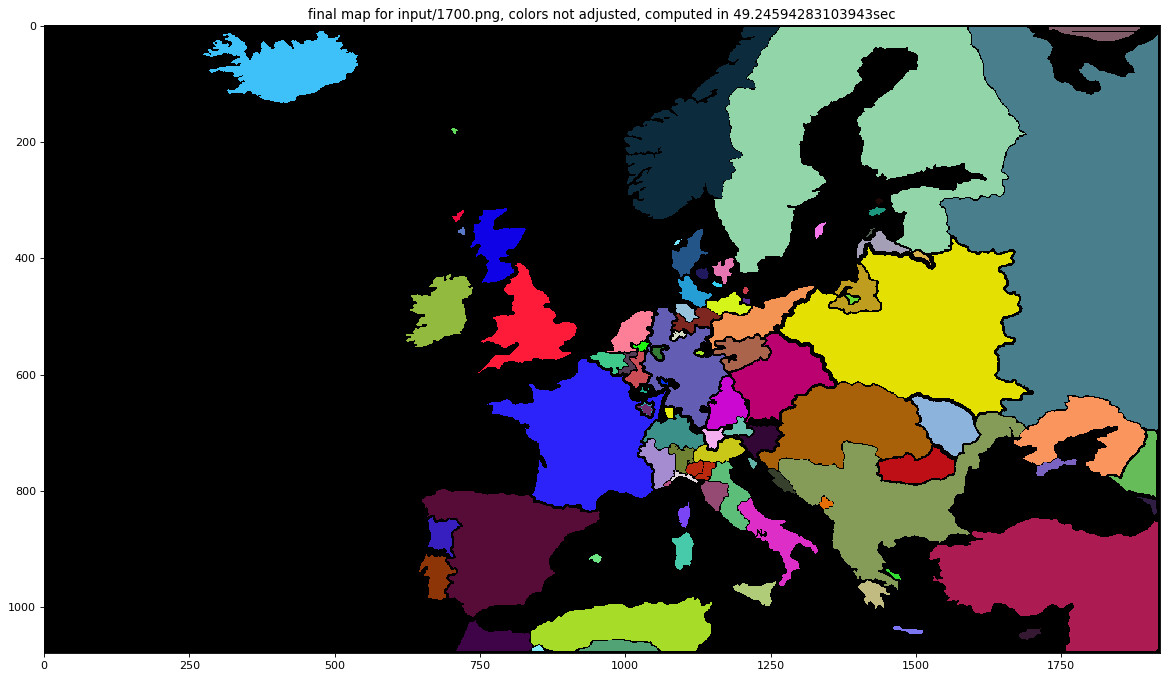

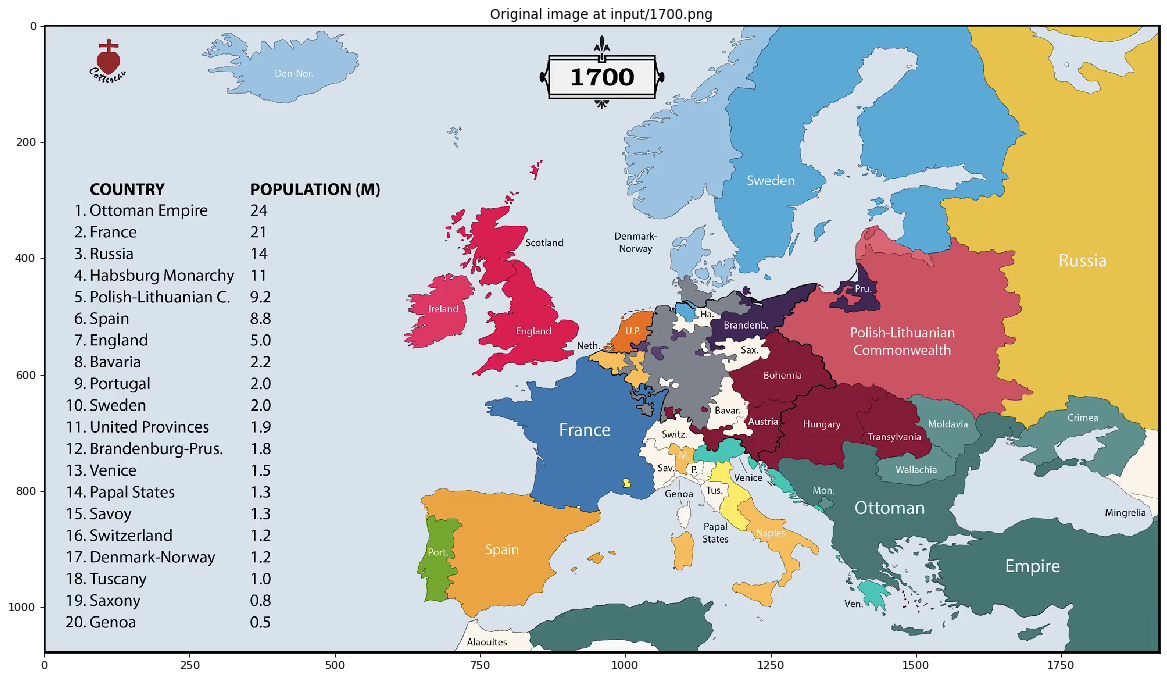

NameError: name 'save_results' is not defined

In [13]:
data_1700 = process_img('input/1700.png')


In [20]:
from shapely.geometry import mapping
import json

def save_results(results, filename):
    serializable_results = [
        {
            "color" : list(col.astype(float)),
            "polygon" : mapping(pol)
        } for col,pol in results
    ]
    json.dump(serializable_results, open(filename, 'w'))

save_results(data_1700, 'output/1700.json')